In [14]:
import pandas as pd
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
IMG_DIR = 'data/images/'

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
#attach image_url in dataframe
train_df['img_url'] = train_df.id.map(lambda x: IMG_DIR + str(x) + '.jpg')
test_df['img_url'] = test_df.id.map(lambda x: IMG_DIR + str(x) + '.jpg')

In [5]:
train_df.sample(3)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,img_url
642,1014,Phildelphus,0.015625,0.042969,0.056641,0.025391,0.001953,0.050781,0.027344,0.0,...,0.0,0.001953,0.008789,0.097656,0.0,0.0,0.003906,0.02832,0.000977,data/images/1014.jpg
129,233,Lithocarpus_Edulis,0.041016,0.167970,0.003906,0.005859,0.000000,0.222660,0.000000,0.0,...,0.0,0.036133,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.001953,data/images/233.jpg
848,1358,Quercus_Canariensis,0.007812,0.001953,0.013672,0.015625,0.009766,0.005859,0.021484,0.0,...,0.0,0.056641,0.003906,0.015625,0.0,0.0,0.000000,0.00000,0.014648,data/images/1358.jpg


In [6]:
test_df.head(3)

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,img_url
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.0,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711,data/images/4.jpg
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.0,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922,data/images/7.jpg
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.0,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000,data/images/9.jpg


In [7]:
print('Types of species: ',train_df.species.value_counts().describe()['count'])
print('Number of samples in each species: ',train_df.species.value_counts().describe()['mean'])
print('Number of train data: ', len(train_df))
print('Number of test data: ', len(test_df))
print('Number of variables: ', len(train_df.columns)-1)

Types of species:  99.0
Number of samples in each species:  10.0
Number of train data:  990
Number of test data:  594
Number of variables:  194


In [8]:
#label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_df.species)
train_df['label']=pd.Series(le.transform(train_df.species.values))

In [9]:
# create validation set
train = train_df.sample(frac=0.9)
val = train_df[~train_df['id'].isin(train['id'])]
test = test_df
print(len(train), len(val), len(test))

891 99 594


In [10]:
# build data loader
class LeafDataset(Dataset):
    def __init__(self, df, training=False, transforms=None):
        self.df = df
        self.tranforms = transforms
        self.training = training
        self.features = self.df.columns.difference(['species','id','img_url','label'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(self.df['img_url'].iloc[idx])
        features = np.array(self.df[self.features].iloc[idx])
        
        if self.tranforms:
            img = self.tranforms(img)
        
        if self.training:
            label = self.df['label'].iloc[idx]
            return img, features, label   
        else:
            return img, features

In [11]:
# img = Image.open(train_df['img_url'].iloc[0])
# scale = transforms.Resize(100)
# randomcrop = transforms.RandomCrop(300, padding=100)
# randomcrop(scale(img))

In [11]:
trans_train= transforms.Compose([transforms.Resize([100,100]),
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(20),
                               transforms.RandomCrop(96),
                               transforms.ToTensor(),
                              ])

trans_test = transforms.Compose([transforms.Resize([96,96]),
                               transforms.ToTensor(),
                              ])

train_ds = LeafDataset(train, training=True, transforms=trans_train)
val_ds = LeafDataset(val, training=True, transforms=trans_train)
test_ds = LeafDataset(test, training=False, transforms=trans_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=32)
val_dl = DataLoader(val_ds, shuffle=True, batch_size=32)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=1)

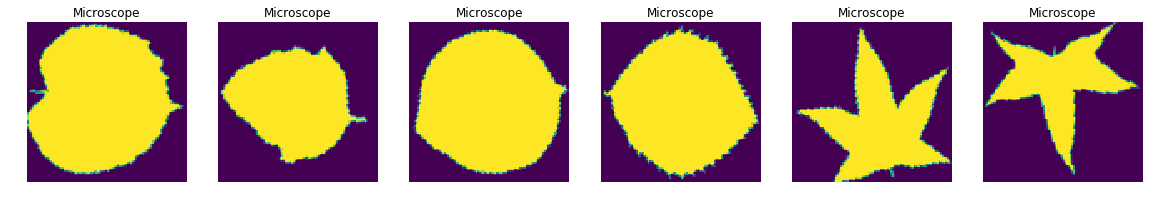

In [12]:
imgs, feas, lbs = next(iter(train_dl))

img_dict_list = []
pilTrans = transforms.ToPILImage()
n_img = 6
for i in range(n_img):
    img = np.asarray(pilTrans(imgs[i]))
    img_dict_list.append(img)

fig, m_axs = plt.subplots(1, n_img, figsize = (20, 5))
for c_row, (c_im) in zip(img_dict_list, m_axs.T):
    c_im.imshow(c_row)
    c_im.axis('off')
    c_im.set_title('Microscope')

In [13]:
def ConvBnRelu(in_planes, out_planes, kernel=3, stride=1, padding=0):
    layers = [
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
    ]
    return nn.Sequential(*layers)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            ConvBnRelu(1, 8, kernel=5, stride=5, padding=1),
            ConvBnRelu(8, 32, kernel=3, stride=3, padding=1),
        )
        self.fc1 = nn.Linear(224,300)
        self.fc2 = nn.Linear(300, 99)

    def forward(self, img, fea):
        x = self.convs(img)
        x = x.view(x.size(0),-1)
#         print(x.shape)
        x = torch.cat((x, fea), 1)
        x = F.relu(self.fc1(x))
        x= F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return(x)
# 55800 + 192

In [24]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for imgs, feas, labels in dataloders[phase]:
               
                imgs, feas, labels = imgs.to(device), feas.type(torch.FloatTensor).to(device), labels.type(torch.LongTensor).to(device)
                
                outputs = model(imgs, feas)
#                 outputs = F.softmax(outputs)
                _, preds = torch.max(outputs, 1)
#                 print(outputs, labels)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [25]:
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
dloaders = {'train':train_dl, 'valid':val_dl}

In [26]:
start_time = time.time()
model = train_model(dloaders, net, criterion, optimizer, exp_lr_scheduler, num_epochs=100)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/99] train loss: 0.1457 acc: 0.0112 valid loss: 0.1841 acc: 0.0202
Epoch [1/99] train loss: 0.1390 acc: 0.0359 valid loss: 0.1729 acc: 0.0303
Epoch [2/99] train loss: 0.1260 acc: 0.0898 valid loss: 0.1550 acc: 0.1111
Epoch [3/99] train loss: 0.1075 acc: 0.1594 valid loss: 0.1322 acc: 0.1313
Epoch [4/99] train loss: 0.0932 acc: 0.2334 valid loss: 0.1036 acc: 0.4646
Epoch [5/99] train loss: 0.0784 acc: 0.3165 valid loss: 0.0909 acc: 0.5556
Epoch [6/99] train loss: 0.0675 acc: 0.3939 valid loss: 0.2056 acc: 0.1111
Epoch [7/99] train loss: 0.0590 acc: 0.4646 valid loss: 0.0606 acc: 0.7374
Epoch [8/99] train loss: 0.0513 acc: 0.5455 valid loss: 0.0523 acc: 0.7778
Epoch [9/99] train loss: 0.0424 acc: 0.6150 valid loss: 0.0435 acc: 0.7980
Epoch [10/99] train loss: 0.0378 acc: 0.6543 valid loss: 0.0278 acc: 0.8586
Epoch [11/99] train loss: 0.0345 acc: 0.6925 valid loss: 0.0279 acc: 0.8788
Epoch [12/99] train loss: 0.0295 acc: 0.7396 valid loss: 0.0316 acc: 0.8283
Epoch [13/99] train lo

In [ ]:
# save and load weight
# torch.save(model.state_dict(), 'backup/val_97.pth')

# model = net
# model.load_state_dict(torch.load('backup/val_97.pth'))

In [27]:
model.eval()
res_list = []
pred_list = []
with torch.no_grad():
    for imgs, feas in test_dl:
        imgs, feas = imgs.to(device), feas.type(torch.FloatTensor).to(device)

        outputs = model(imgs, feas)
        outputs_softmax = F.softmax(outputs, dim=1)
        rs, preds = torch.max(outputs_softmax.data, 1)
        
        pred_list.append(preds)
        res_list.append(outputs_softmax.cpu().numpy())

In [29]:
submit_df = pd.read_csv('data/sample_submission.csv')

res_df = pd.DataFrame(np.concatenate(res_list))
res_df = pd.concat([submit_df['id'], res_df], axis=1)
res_df.columns = list(submit_df.columns)
# res_df.to_csv('submission.csv', index=False)
res_df.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.164868e-08,1.099573e-09,1.239468e-10,5.732471e-04,8.192371e-13,3.562257e-12,3.219124e-07,7.704753e-11,1.539659e-10,...,1.425098e-10,7.832612e-07,5.413344e-08,3.483350e-08,1.325714e-05,2.686233e-07,6.012938e-13,6.315263e-08,8.833484e-09,3.642675e-08
1,7,5.376264e-10,1.336452e-06,2.507748e-08,5.310162e-05,8.289605e-09,2.451269e-08,9.501298e-05,7.458647e-08,2.393196e-09,...,1.103966e-10,4.713933e-09,2.620962e-10,6.624311e-08,7.432810e-09,1.045423e-07,5.269515e-13,3.863034e-08,5.026252e-12,2.952805e-04
2,9,3.252241e-08,9.876696e-01,1.013868e-08,2.599223e-10,1.055704e-02,3.723549e-10,1.194247e-07,5.704889e-08,4.074213e-04,...,1.738572e-08,1.890784e-15,6.099503e-14,1.001608e-10,1.110802e-11,4.393645e-09,1.460254e-09,2.791018e-17,5.491859e-18,2.096053e-04
3,12,5.830582e-08,1.390131e-03,1.925702e-12,2.240954e-09,1.216763e-08,4.607107e-14,4.825189e-04,1.138235e-06,4.962165e-04,...,3.523634e-08,1.269159e-14,1.952845e-07,4.553103e-10,4.701498e-06,2.105550e-04,3.386973e-04,4.834063e-12,2.325938e-13,3.766346e-04
4,13,5.656874e-07,1.591882e-06,5.200309e-17,1.317810e-12,9.190870e-09,1.023825e-18,1.965028e-06,5.514435e-09,2.370487e-04,...,2.919091e-05,7.476174e-16,5.489480e-07,7.696265e-10,2.322260e-04,2.119975e-05,2.977567e-03,4.916509e-12,2.019009e-12,1.571491e-09
